# Techniques for dealing with class imbalance: A case of detecting fraud from Credit Card transactions dataset

### Introduction
Machine learning models generally require some amount of data to train the model and in virtually all cases, the more the training data the better the model performance. Hence, when insufficient data is provided, what readily comes to mind is to ask for more training data to train the model. However, there are some modeling problems that by nature do not have large enough data. Typical examples include Fraud detection, Customer Churn, Insurance claim, diseases prediction e.tc. This is so because we do not expect so many incidents of fraud or the other examples in this categories to happen frequently. This situation gives rise to a dataset where the positive class (the case we are interested in e.g. Fraud) is relatively small compared to the negative class (i.e. No Fraud). The dataset for the Credit card case considered in this tutorial, for example, has 99.8% negative class (i.e. No fraud) and just 0.2% positive class (i.e. Fraud). Training a ML model on such dataset often result to poor performance as the model does not have sufficient examples of the positive class to give an accurate prediction when used to predict on new (unseen) dataset. I believe this is a common problem in the industry and this tutorial will explore the various techniques that are available in dealing with extreme imbalance dataset such as this. 

### Dataset and Approach
In this tutorial, I will be using a Credit Card fraud Dataset from Kaggle available at https://www.kaggle.com/mlg-ulb/creditcardfraud/data and will be evaluating different techniques and resampling strategies using only one single ML model i.e. Logistic Regression. The idea here is to keep the ML model (i.e. Logistic Regression) the same so as to be able to evaluate the impact of the different techniques on the performance of the model. Given the sensitive nature of the data (Credit card details), the data were de-identified by creating 28 principal components (i.e. V1 to V28) using PCA

There are several techniques in dealing with class imbalance but I will be looking at 2 major techniques in this tutorial namely: Cost-sensitive Learning and Sampling i.e. Undersampling, Oversampling, and Hybrid (Undersampling + Oversampling) and each of these has several implementations some of which are discussed below

### Metrics
When dealing with imbalanced classification problems, it is imperative to consider using metrics beyond accuracy as this may look deceptively impressive. The Credit card case considered in this tutorial, for example, has 99.8% negative (No fraud) examples in the training data set and simply predicting all data as negative gives an accuracy of 99.8% which is totally wrong. Hence, for this particular problem, we will be using recall, precision, Confusion Matrix and AUC(Area Under the ROC curve) as our metric. I will also be visualizing the Training Dataset (2 Principal Component) with a fitted line to have an overview of what happened during the training phase.

In [142]:
# Import the required libraries for this task
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib
plt.style.use('seaborn')
import seaborn as sns 
import numpy as np
import datetime 
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler, NearMiss, CondensedNearestNeighbour
from imblearn.under_sampling import EditedNearestNeighbours, RepeatedEditedNearestNeighbours,TomekLinks
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.ensemble import EasyEnsemble, BalanceCascade
from sklearn.model_selection import GridSearchCV, train_test_split, KFold 
from sklearn.metrics import confusion_matrix,roc_auc_score,classification_report,roc_curve, precision_recall_fscore_support
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

### Data Cleaning, Pre-processing and Visualization
We load the data from CSV, standardize the ampount column and display the top 5

In [60]:
# Load data 
data = pd.read_csv("creditcard.csv")

# Let's standardize the ampount column and display top 5
data["Amount"] = StandardScaler().fit_transform(data['Amount'].reshape(-1, 1))
data.drop(["Time"],axis=1,inplace=True)
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


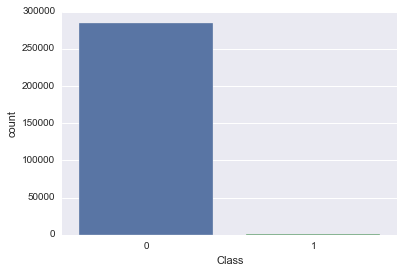

percentage of normal transacation is 99.82725143693798
percentage of fraud transacation 0.17274856306201514


In [143]:
# Now lets check the class distributions
# normal transaction are repersented by 0 and fraud by 1
sns.countplot("Class",data=data)
plt.show()

# checking the number of Percentage
Normal_tran = len(data[data["Class"]==0]) 
Fraud_tran = len(data[data["Class"]==1]) 
Normal_tran_Percent = Normal_tran/(Normal_tran+Fraud_tran) * 100
print("percentage of normal transacation is",Normal_tran_Percent)
print("percentage of fraud transacation",100-Normal_tran_Percent)

### Create set of Functions to be used for visualization, Evaluation and Prediction

In [144]:
# Function to help with plotting in 2d
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')

In [145]:
# Function to help in generating confusion Matrix
def confusion_mat(truth, stream):

    cm = confusion_matrix(truth, stream)
    matplotlib.rcParams['figure.figsize'] = (6.0, 3.0)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True,annot_kws={"size": 18}, ax = ax, cmap="Blues", cbar=False, fmt='.5g'); 
    ax.set_xlabel('Predicted labels');ax.set_ylabel('Actual labels'); 
    ax.xaxis.set_label_position('top') 
    ax.xaxis.set_ticklabels(['False','True']); ax.yaxis.set_ticklabels(['False','True']);
    ax.xaxis.set_ticks_position('top')
    return plt.show()

In [146]:
# Function to help generate ROC Curve
auc_r = []
technique = []
def auc_roc(y_test, prediction):
    #plt.style.use('ggplot')
    matplotlib.rcParams['figure.figsize'] = (6.0, 4.5)
    fpr, tpr, thresholds = roc_curve(y_test, prediction, pos_label=1)
    auc = np.trapz(tpr, fpr)
    global auc_r
    auc_r.append(auc)
    plt.plot(fpr, tpr, label="AUC=" + str(auc))
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend(loc='upper left')
    plt.show() 

In [147]:
# Function to help in Cross Validation, hyperparameter tunning and Prediction
from sklearn.model_selection import GridSearchCV
def model(lr,X_train,y_train,X_test,y_test):
    param_grid = {"C": [0.01, 1.0, 10, 100]} 
    model = GridSearchCV(lr, param_grid=param_grid, cv=5, scoring = 'f1')
    model.fit(X_train,y_train)
    prediction=model.predict(X_test)
    auc_roc(y_test, prediction)
    confusion_mat(y_test, prediction)
    print(classification_report(y_test, prediction))

    # Plot Data
    coef = model.best_estimator_.coef_
    intercept = model.best_estimator_.intercept_
    x1 = np.linspace(-60, 10, 100)
    x2 = -(coef[0][0] * x1 + intercept[0]) 
    plot_2d_space(X_train[:,0:2], y_train, 'Training Dataset (2 PCA components)')
    plt.plot(x1, x2, color= "#414e8a", linewidth = 2)
    plt.show()

### Split data into train and Test (Stratified) and visualize the first 2 Principal Components

In [148]:
# Split Data to train and test
y = data['Class']
X = data.drop(['Class'], axis =1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=100, stratify=y)

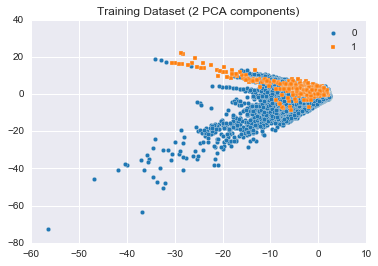

In [149]:
# Visualizing the first 2 principal component of the training Data 
plot_2d_space(X_train[['V1','V2']].values, y_train.values, 'Training Dataset (2 PCA components)')

### Get the Base line performance of the chosen model i.e. Logistic Regression without considering imbalance

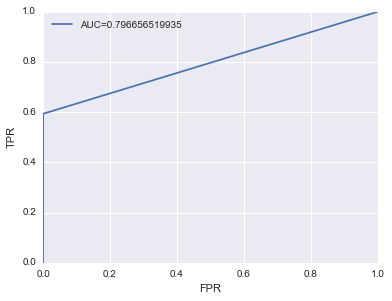

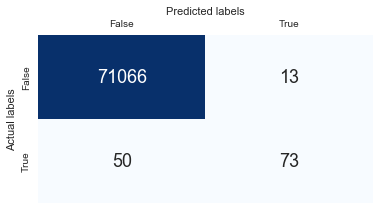

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     71079
          1       0.85      0.59      0.70       123

avg / total       1.00      1.00      1.00     71202



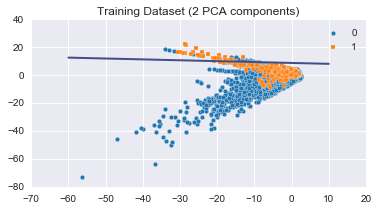

In [150]:
# Logistic Regression
X_train, X_test, y_train, y_test = X_train.values, X_test.values, y_train.values, y_test.values
lr = LogisticRegression()
model(lr,X_train,y_train,X_test,y_test)
technique.append('BenchMark')

## Dealing with class imbalance
Now that we can see the baseline performance working with the data "as is", we will now start evaluating each of the techniques for dealing with imbalance class mentioned above on the datasaet.

### Cost-sensitive Learning
In regular learning, we treat all misclassifications equally, which causes issues in imbalanced classification problems, as there is no extra reward for identifying the minority class over the majority class. Cost-sensitive learning changes this, and uses a function C(p, t) (usually represented as a matrix) that specifies the cost of misclassifying an instance of class t (true label) as class p (predicted label). This allows us to penalize misclassifications of the minority class more heavily than we do with misclassifications of the majority class, in hopes that this increases the true positive rate. In scikit-learn, this can be done for supported classifiers by setting the "class weight" parameter to "balanced".

In [215]:
#Table 1. An example of cost matrix for binary classification.
#
#                  ************************************
#                  * Actual negative * Actual positive*
# *****************************************************
# Predict negative * C(0,0), or TN   * C(0,1), or FN  *
# *****************************************************
# Predict positive * C(1,0), or FP   * C(1,1), or TP  *
# *****************************************************

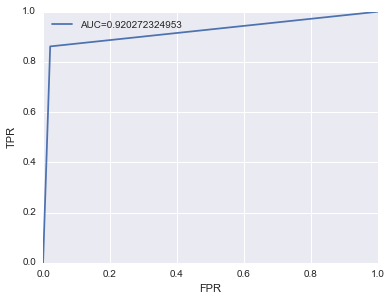

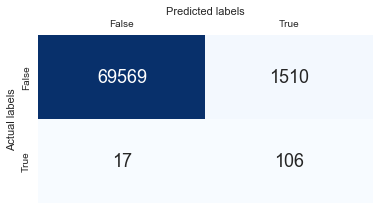

             precision    recall  f1-score   support

          0       1.00      0.98      0.99     71079
          1       0.07      0.86      0.12       123

avg / total       1.00      0.98      0.99     71202



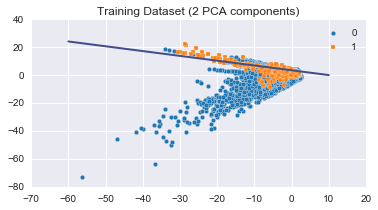

In [151]:
# Logistic Regression + wieght balance
lr = LogisticRegression(class_weight ='balanced')
model(lr,X_train,y_train,X_test,y_test)
technique.append('Cost-sensitive')

## Sampling
A simple way to fix imbalanced data-sets is simply to balance them, either by oversampling instances of the minority class or undersampling instances of the majority class. This simply allows us to create a balanced data-set that, in theory, should not lead to classifiers biased toward one class or the other. In this tutorial, I will explore 3 forms of sampling which are Undersampling, Oversampling and Hybrid (Undersampling + Oversampling).


### Undersampling
One of the most common and simplest strategies to handle imbalanced data is to undersample the majority class. while it may work well on some dataset, undersampling the majority may result in leaving out important instances that provide important differences between the two classes. Discussed below are some undersampling techniques

##### 1.0 Random UnderSampling
This involves randomly undersampling examples from the majority class. As earlier mentioned, these may lead to a loss of information.
<img src="files/rus.png">

Distribution of class labes before undersamping: Counter({0: 213236, 1: 369})
Distribution of class labes after undersamping: Counter({0: 369, 1: 369})


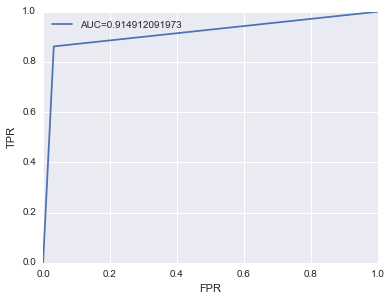

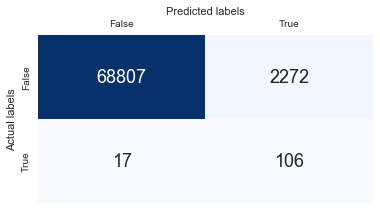

             precision    recall  f1-score   support

          0       1.00      0.97      0.98     71079
          1       0.04      0.86      0.08       123

avg / total       1.00      0.97      0.98     71202



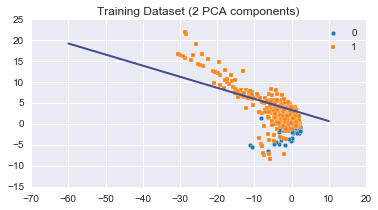

In [165]:
# Logistic Regression + Random UnderSampling of majority class
rus = RandomUnderSampler(ratio=1, random_state=1)
X_train_res, y_train_res = rus.fit_sample(X_train, y_train)
print("Distribution of class labes before undersamping:", Counter(y_train))
print("Distribution of class labes after undersamping:", Counter(y_train_res))
lr = LogisticRegression()
model(lr,X_train_res,y_train_res,X_test,y_test)
technique.append('RandomUnderSampler')

#### 2.0 NearMiss
The NearMiss family of methods perform undersampling of points in the majority class based on their distance to other points in the same class. There are 3 variants of these namely NearMiss-1, NearMiss-2 and NearMiss-3

##### 2.1 NearMiss-1
In NearMiss-1, those points from majority class (i.e. No Fraud) whose mean distance to the k nearest points in minority class is lowest are retained, where k is a tunable hyperparameter.
<img src="files/nearmiss1A.png">

Distribution of class labes before undersamping: Counter({0: 213236, 1: 369})
Distribution of class labes after undersamping: Counter({0: 369, 1: 369})


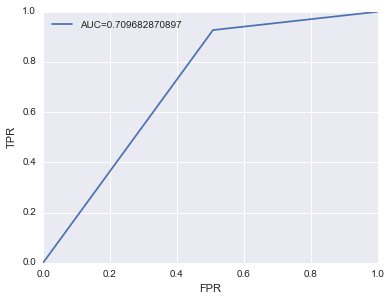

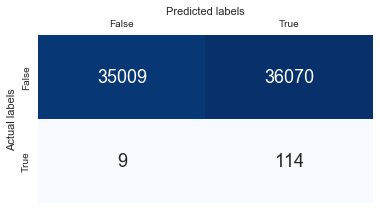

             precision    recall  f1-score   support

          0       1.00      0.49      0.66     71079
          1       0.00      0.93      0.01       123

avg / total       1.00      0.49      0.66     71202



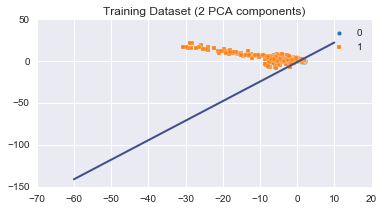

In [166]:
# Logistic Regression + NearMiss 1
lr = LogisticRegression()
us = NearMiss(ratio=1, random_state=1, n_neighbors=3, version=1)
X_train_res, y_train_res = us.fit_sample(X_train, y_train)
print("Distribution of class labes before undersamping:", Counter(y_train))
print("Distribution of class labes after undersamping:", Counter(y_train_res))
model(lr,X_train_res,y_train_res,X_test,y_test)
technique.append('NearMiss1')

###### 2.2 NearMiss-2
In contrast to NearMiss-1, NearMiss-2 keeps those points from majority class whose mean distance to the k farthest points in minority class is lowest.
<img src="files/nearmiss2.png">

Distribution of class labes before undersamping: Counter({0: 213236, 1: 369})
Distribution of class labes after undersamping: Counter({0: 369, 1: 369})


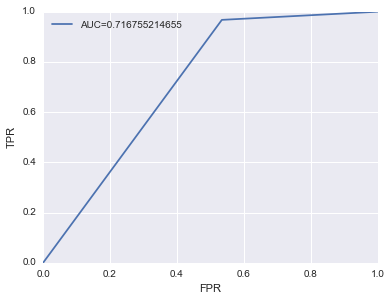

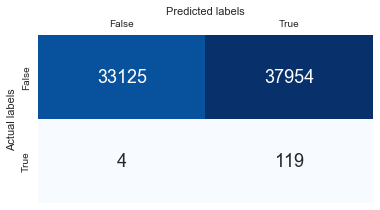

             precision    recall  f1-score   support

          0       1.00      0.47      0.64     71079
          1       0.00      0.97      0.01       123

avg / total       1.00      0.47      0.63     71202



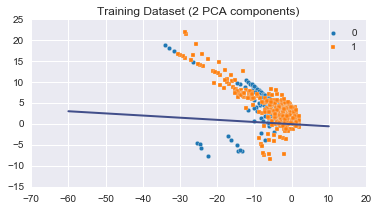

In [167]:
# Logistic Regression + NearMiss 2
lr = LogisticRegression()
us = NearMiss(ratio=1, random_state=1, n_neighbors=3, version=2)
X_train_res, y_train_res = us.fit_sample(X_train, y_train)
print("Distribution of class labes before undersamping:", Counter(y_train))
print("Distribution of class labes after undersamping:", Counter(y_train_res))
model(lr,X_train_res,y_train_res,X_test,y_test)
technique.append('NearMiss2')

###### 2.3 NearMiss-3
NearMiss-3, the last NearMiss variant selects k nearest neighbors in the majority class for every point in the minority class. In this case, the undersampling ratio is directly controlled by k and is not separately tuned.
<img src="files/nearmiss3.png">

Distribution of class labes before undersamping: Counter({0: 213236, 1: 369})
Distribution of class labes after undersamping: Counter({1: 369, 0: 303})


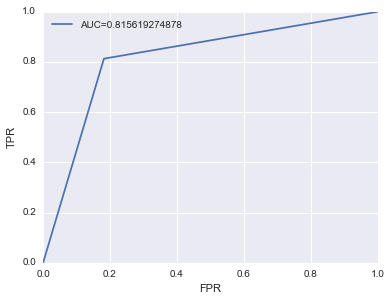

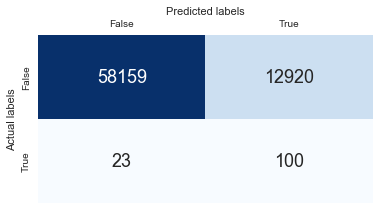

             precision    recall  f1-score   support

          0       1.00      0.82      0.90     71079
          1       0.01      0.81      0.02       123

avg / total       1.00      0.82      0.90     71202



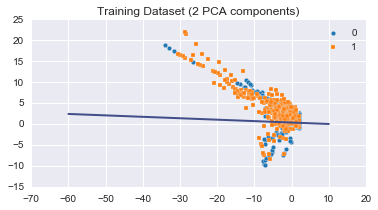

In [168]:
# Logistic Regression + NearMiss 3
lr = LogisticRegression()
us = NearMiss(ratio=1, random_state=1, n_neighbors=3, version=3)
X_train_res, y_train_res = us.fit_sample(X_train, y_train)
print("Distribution of class labes before undersamping:", Counter(y_train))
print("Distribution of class labes after undersamping:", Counter(y_train_res))
model(lr,X_train_res,y_train_res,X_test,y_test)
technique.append('NearMiss3')

##### Condensed Nearest Neighbor (CNN)
In CNN undersampling, the goal is to choose a subset of the training set such that for every point in the training set, its nearest neighbor in the subset is of the same class. Undersampling via CNN can be slower compared to other methods since it requires many passes over the training data. Further, because of the randomness involved in the selection of points at each iteration, the subset selected can vary significantly.

A variant of CNN is to only undersample the majority class i.e. retain all points from minority class but retain only those points in majority class that belong to the subset. 

<img src="files/cnn.png">

Distribution of class labes before undersamping: Counter({0: 213236, 1: 369})
Distribution of class labes after undersamping: Counter({0: 787, 1: 369})


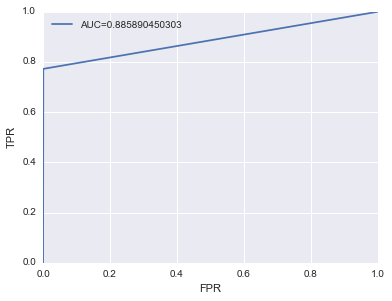

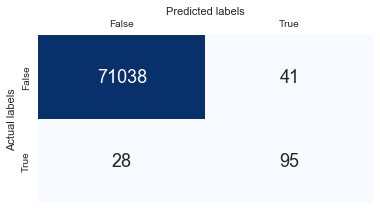

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     71079
          1       0.70      0.77      0.73       123

avg / total       1.00      1.00      1.00     71202



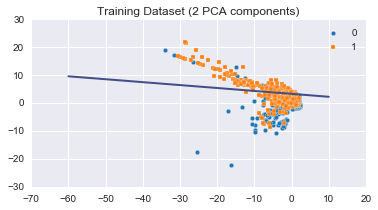

In [169]:
# Logistic Regression + CondensedNearestNeighbour
lr = LogisticRegression()
us = CondensedNearestNeighbour(random_state=1)
X_train_res, y_train_res = us.fit_sample(X_train, y_train)
print("Distribution of class labes before undersamping:", Counter(y_train))
print("Distribution of class labes after undersamping:", Counter(y_train_res))
model(lr,X_train_res,y_train_res,X_test,y_test)
technique.append('CondensedNearestNeighbour')

#####  Edited Nearest Neighbor (ENN) / Repeated Edited Nearest Neighbor
In ENN, undersampling of the majority class is done by removing points whose class label differs from a majority of its k nearest neighbors.

A variant of ENN is Repeated ENN, In Repeated Edited Nearest Neighbor, the ENN algorithm is applied successively until ENN can remove no further points

<img src="files/enn.png">

C:\ProgramData\Anaconda3\lib\site-packages\imblearn\utils\deprecation.py:50: DeprecationWarning: 'size_ngh' is deprecated from 0.2 and will be removed in 0.4. Use 'n_neighbors' instead.
  category=DeprecationWarning)


Distribution of class labes before undersamping: Counter({0: 213236, 1: 369})
Distribution of class labes after undersamping: Counter({0: 213059, 1: 369})


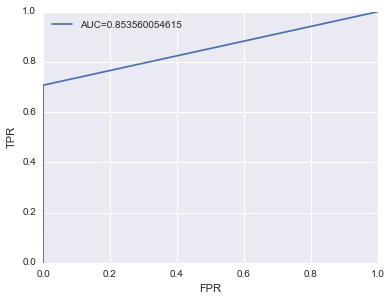

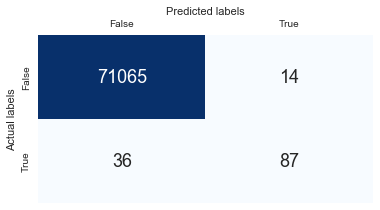

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     71079
          1       0.86      0.71      0.78       123

avg / total       1.00      1.00      1.00     71202



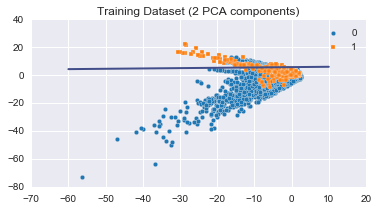

In [170]:
# Logistic Regression + EditedNearestNeighbours
lr = LogisticRegression()
us = EditedNearestNeighbours(size_ngh=5, random_state=1)
X_train_res, y_train_res = us.fit_sample(X_train, y_train)
print("Distribution of class labes before undersamping:", Counter(y_train))
print("Distribution of class labes after undersamping:", Counter(y_train_res))
model(lr,X_train_res,y_train_res,X_test,y_test)
technique.append('EditedNearestNeighbours')

Distribution of class labes before undersamping: Counter({0: 213236, 1: 369})
Distribution of class labes after undersamping: Counter({0: 213085, 1: 369})


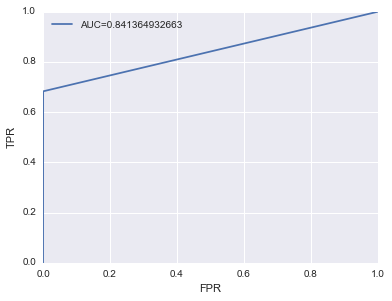

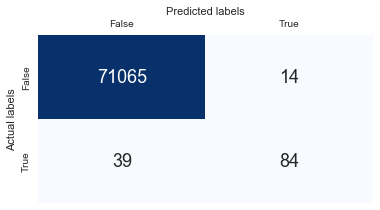

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     71079
          1       0.86      0.68      0.76       123

avg / total       1.00      1.00      1.00     71202



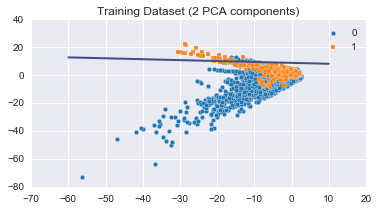

In [171]:
# Logistic Regression + RepeatedEditedNearestNeighbours
lr = LogisticRegression()
us = RepeatedEditedNearestNeighbours(size_ngh=5, random_state=1)
X_train_res, y_train_res = us.fit_sample(X_train, y_train)
print("Distribution of class labes before undersamping:", Counter(y_train))
print("Distribution of class labes after undersamping:", Counter(y_train_res))
model(lr,X_train_res,y_train_res,X_test,y_test)
technique.append('RepeatedEditedNearestNeighbours')

#####  Tomek Link Removal
A pair of examples is called a Tomek link if they belong to different classes and are each other’s nearest neighbors. Undersampling can be done by removing all tomek links from the dataset. An alternate method is to only remove the majority class samples that are part of a Tomek link.
<img src="files/tomeklink.png">

Distribution of class labes before undersamping: Counter({0: 213236, 1: 369})
Distribution of class labes after undersamping: Counter({0: 213213, 1: 369})


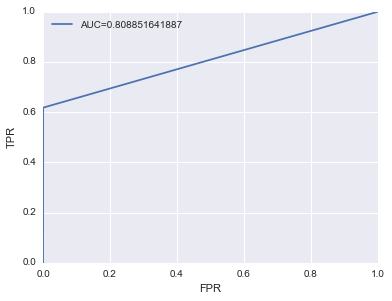

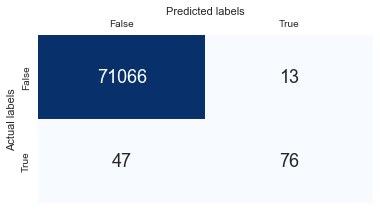

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     71079
          1       0.85      0.62      0.72       123

avg / total       1.00      1.00      1.00     71202



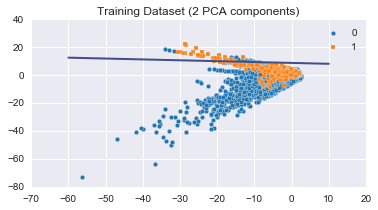

In [172]:
# Logistic Regression + Tomek Links removal
lr = LogisticRegression()
us = TomekLinks(random_state=1)
X_train_res, y_train_res = us.fit_sample(X_train, y_train)
print("Distribution of class labes before undersamping:", Counter(y_train))
print("Distribution of class labes after undersamping:", Counter(y_train_res))
model(lr,X_train_res,y_train_res,X_test,y_test)
technique.append('TomekLinks')

### Oversampling
At the other end of the spectrum are methods that oversample points from the minority class. Discussed below are some oversampling techniques.

#### Random oversampling of minority class
Points from the minority class may be oversampled with replacement. Random oversampling of minority class can lead to model overfitting, since it will introduce duplicate instances, drawing from a pool of instances that is already small

Distribution of class labes before undersamping: Counter({0: 213236, 1: 369})
Distribution of class labes after undersamping: Counter({0: 213236, 1: 106618})


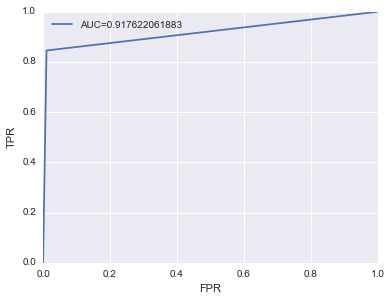

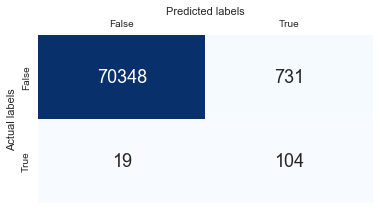

             precision    recall  f1-score   support

          0       1.00      0.99      0.99     71079
          1       0.12      0.85      0.22       123

avg / total       1.00      0.99      0.99     71202



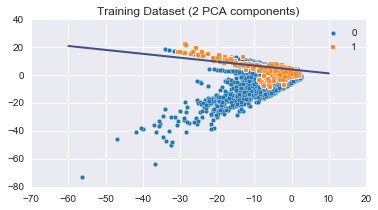

In [173]:
# OVERSAMPLING
# Logistic Regression + RandomOverSampler
lr = LogisticRegression()
os = RandomOverSampler(ratio=0.5, random_state=1)
X_train_res, y_train_res = os.fit_sample(X_train, y_train)
print("Distribution of class labes before undersamping:", Counter(y_train))
print("Distribution of class labes after undersamping:", Counter(y_train_res))
model(lr,X_train_res,y_train_res,X_test,y_test)
technique.append('RandomOverSampler')

#### SMOTE
A more sophisticated means for oversampling is Synthetic Minority Oversampling Technique (SMOTE). SMOTE creates new instances of the minority class by forming convex combinations of neighboring instances. As the graphic below shows, it effectively draws lines between minority points in the feature space, and samples along these lines. This allows us to balance our data-set without as much overfitting, as we create new synthetic examples rather than using duplicates. This however does not prevent all overfitting, as these are still created from existing data points.
<img src="files/smote.png">

Distribution of class labes before undersamping: Counter({0: 213236, 1: 369})
Distribution of class labes after undersamping: Counter({0: 213236, 1: 106618})


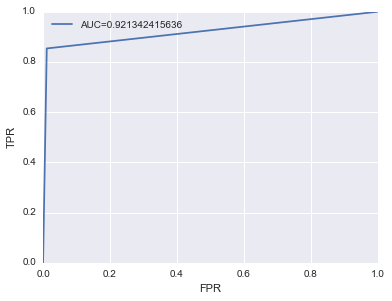

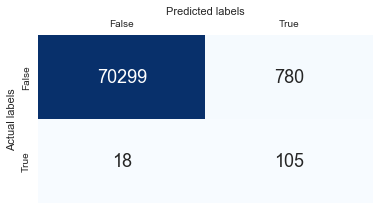

             precision    recall  f1-score   support

          0       1.00      0.99      0.99     71079
          1       0.12      0.85      0.21       123

avg / total       1.00      0.99      0.99     71202



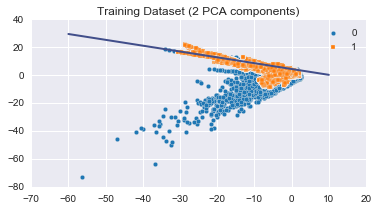

In [174]:
# OVERSAMPLING
# Logistic Regression + SMOTE
lr = LogisticRegression()
os = SMOTE(ratio=0.5, k_neighbors=5, random_state=1)
X_train_res, y_train_res = os.fit_sample(X_train, y_train)
print("Distribution of class labes before undersamping:", Counter(y_train))
print("Distribution of class labes after undersamping:", Counter(y_train_res))
model(lr,X_train_res,y_train_res,X_test,y_test)
technique.append('SMOTE')

### Hybrid
Performing a combination of oversampling and undersampling can often yield better results than either in isolation.
We discuss two particular combinations here
    
    SMOTE + Tomek Link Removal: Oversampling using SMOTE followed by undersampling using Tomek Link Removal
    SMOTE + ENN: Oversampling using SMOTE followed by undersampling using ENN

C:\ProgramData\Anaconda3\lib\site-packages\imblearn\utils\deprecation.py:50: DeprecationWarning: 'k' is deprecated from 0.2 and will be removed in 0.4. Use 'k_neighbors' instead.
  category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\imblearn\utils\deprecation.py:50: DeprecationWarning: 'm' is deprecated from 0.2 and will be removed in 0.4. Use 'm_neighbors' instead.
  category=DeprecationWarning)


Distribution of class labes before undersamping: Counter({0: 213236, 1: 369})
Distribution of class labes after undersamping: Counter({0: 213236, 1: 106618})


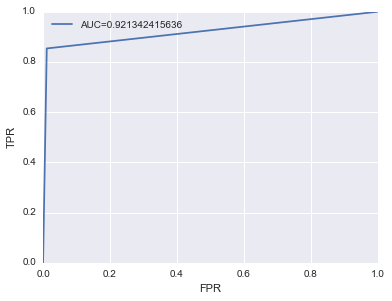

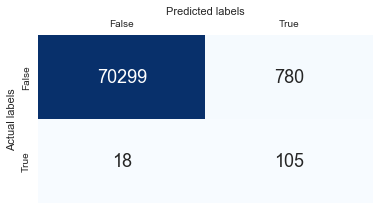

             precision    recall  f1-score   support

          0       1.00      0.99      0.99     71079
          1       0.12      0.85      0.21       123

avg / total       1.00      0.99      0.99     71202



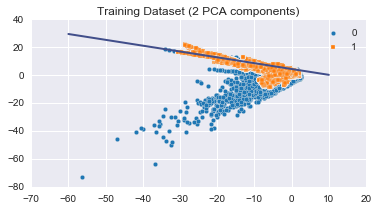

In [175]:
# Hybrid
# Logistic Regression + SMOTETomek
lr = LogisticRegression()
os_us = SMOTETomek(ratio=0.5, k=5, random_state=1)
X_train_res, y_train_res = os_us.fit_sample(X_train, y_train)
print("Distribution of class labes before undersamping:", Counter(y_train))
print("Distribution of class labes after undersamping:", Counter(y_train_res))
model(lr,X_train_res,y_train_res,X_test,y_test)
technique.append('SMOTETomek')

C:\ProgramData\Anaconda3\lib\site-packages\imblearn\utils\deprecation.py:50: DeprecationWarning: 'k' is deprecated from 0.2 and will be removed in 0.4. Use 'k_neighbors' instead.
  category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\imblearn\utils\deprecation.py:50: DeprecationWarning: 'm' is deprecated from 0.2 and will be removed in 0.4. Use 'm_neighbors' instead.
  category=DeprecationWarning)


Distribution of class labes before undersamping: Counter({0: 213236, 1: 369})
Distribution of class labes after undersamping: Counter({0: 212712, 1: 106617})


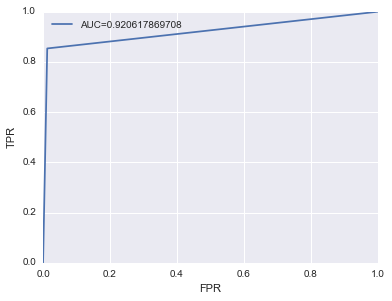

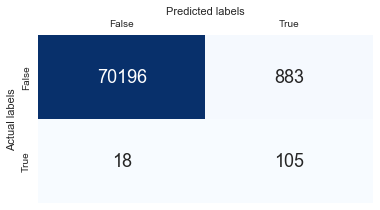

             precision    recall  f1-score   support

          0       1.00      0.99      0.99     71079
          1       0.11      0.85      0.19       123

avg / total       1.00      0.99      0.99     71202



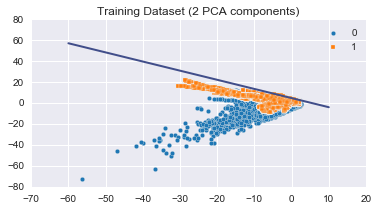

In [177]:
# Hybrid
# Logistic Regression + SMOTEENN
lr = LogisticRegression()
os_us = SMOTEENN(ratio=0.5, k=5, n_neighbors=5, random_state=1)
X_train_res, y_train_res = os_us.fit_sample(X_train, y_train)
print("Distribution of class labes before undersamping:", Counter(y_train))
print("Distribution of class labes after undersamping:", Counter(y_train_res))
model(lr,X_train_res,y_train_res,X_test,y_test)
technique.append('SMOTEENN')

## Conclusion
The table below shows a summary of the AUCs of the different techniques used to deal with the imbalance class issue. While two of the techniques i.e. Nearmiss1 and Nearmiss2  did perform worse than the benchmark for this particular dataset, all of the other techniques did better than the benchmark performance with the top 3 techniques being SMOTE, SMOTETomek, and SMOTEENN. Hence, these techniques are worth considering whenever we have ML problem with Dataset having an extreme imbalance.

In [213]:
# Display Metrics of each Method and Compare with benchmark(i.e. Logistic Regression with no consideration for imbalance)
metric = sorted(list(zip(technique,auc_r)), key=lambda x: x[1], reverse=True)
df = pd.DataFrame(metric, columns = ['Method', 'AUC'])
df['BenchMark'] = df[df['Method']=='BenchMark']['AUC'].tolist()[0]
df['performance_gain%'] = (df['AUC'] - df['BenchMark'])/df['BenchMark'] * 100
df

,Method,AUC,BenchMark,performance_gain%
0,SMOTE,0.921342,0.796657,15.651149
1,SMOTETomek,0.921342,0.796657,15.651149
2,SMOTEENN,0.920618,0.796657,15.560200
3,Cost-sensitive,0.920272,0.796657,15.516826
4,RandomOverSampler,0.917622,0.796657,15.184153
5,RandomUnderSampler,0.914912,0.796657,14.843985
6,CondensedNearestNeighbour,0.885890,0.796657,11.201054
7,EditedNearestNeighbours,0.853560,0.796657,7.142794
8,RepeatedEditedNearestNeighbours,0.841365,0.796657,5.612006
9,NearMiss3,0.815619,0.796657,2.380292


### References
    https://towardsdatascience.com/dealing-with-imbalanced-classes-in-machine-learning-d43d6fa19d2
    https://www.marcoaltini.com/blog/dealing-with-imbalanced-data-undersampling-oversampling-and-proper-cross-validation
    http://www.chioka.in/class-imbalance-problem/
    https://arxiv.org/pdf/1608.06048.pdf
    https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/
    https://www.youtube.com/watch?v=-Z1PaqYKC1w
    http://www.csd.uwo.ca/faculty/ling/papers/cost_sensitive.pdf